# Expected Calibration Error
> 


ECE quantifies how much you can trust the class confidences your model gives. It is the difference between the predicted confidence and reality. 

## How to compute the Caliberation Error?

Computing calibration error is simple. First run your model over a set of samples and collect all the predictions. We need to compute two things. The accuracy of the predictions and the average confidence of all the predictions. 

The absolute difference between the two is calibration error.

In [38]:
#hide
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import numpy as np

In [39]:
def compute_accuracy(predictions, targets):
    assert predictions.shape==targets.shape
    return np.mean(predictions==targets)

def compute_caliberation_error(class_confidences, gt_idxs):
    predicted_class_idxs = np.argmax(class_confidences,axis=1)
    acc = compute_accuracy(predicted_class_idxs, gt_idxs)
    conf = np.max(class_confidences,axis=1).mean()
    return np.absolute(acc-conf),acc,conf

## Expected Caliberation Error 

A classifier is said to be well calibrated if it has a low ECE. I came across Expected Calibration Error from a recent, aptly titled paper “[*Your classifier is secretly an energy based model and you should treat it like one*](https://arxiv.org/abs/1912.03263)”. It defines ECE as

$$ECE = \sum _{m=1}^{M} \frac{|B_m|}{n} |acc(B_m) - conf(B_m)|$$

To compute ECE of a model, we simply bins the predictions first. Then, calculate average of all the calibration errors. 

In [40]:
def expected_caliberation_error(class_confidences,gt_idxs, num_bins=20):
    delta = 1.0/num_bins
    predicted_confidences = np.max(class_confidences,axis=1)
    data = []
    for l in np.arange(0.0,1.0,delta):
        h = l+delta
        # bin the predictions
        idxs = np.argwhere((predicted_confidences<=h) & (predicted_confidences>l)).flatten()
        if len(idxs)==0:continue
        
        # compute caliberation error
        ce,acc,conf = compute_caliberation_error(class_confidences[idxs,:], gt_idxs[idxs])
        data.append([l,h,ce,acc,conf])
    
    # average the computed caliberation errors
    ece = np.mean([ce for _,_,ce,_,_ in data])
    return ece, data

In [41]:
# hide
from fastai.vision import *
from fastai.metrics import error_rate
import fastai
# data
path = untar_data(URLs.IMAGEWOOF_160)
tfms = get_transforms()
data = ImageDataBunch.from_folder(path, train='train', valid='val', ds_tfms = tfms,size=160)
# learner
learner = cnn_learner(data, models.resnet18, metrics=[accuracy, error_rate])
learner.freeze()
# learner.save('stage-0')
# learner.fit(3)
# learner.save('stage-1')

For testing, I fine-tuned a model with resnet18 stem and computed predictions over [ImageWoof](https://github.com/fastai/imagenette) dataset. 

In [42]:
#hide
def plot_figure(x,y,delta):
    plt.figure(figsize=(5,5))
    axes = plt.gca()
    axes.set_xlim([0,1.0])
    axes.set_ylim([0,1.0])
    axes.set_xlabel("confidence")
    axes.set_ylabel("accuracy")
    axes.axis('equal')
    axes.set_aspect('equal', 'box')
    plt.bar(x,y,width=0.9*delta,color="red")#,"ob")
    plt.plot([0,1],[0,1],"--",color="grey")
    plt.title(f"ECE:{round(ece,4)}")
    plt.show()

Before training, the model has very high ECE

In [43]:
learner.load('stage-0');
probs, targets = learner.get_preds()
class_confidences ,gt_idxs = probs.numpy(), targets.numpy()
ece, data = expected_caliberation_error(class_confidences,gt_idxs)

In [44]:
# hide
x = [l for l,h,ce,acc,conf in data]
y = [acc for l,h,ce,acc,conf in data]
delta = 1.0/20

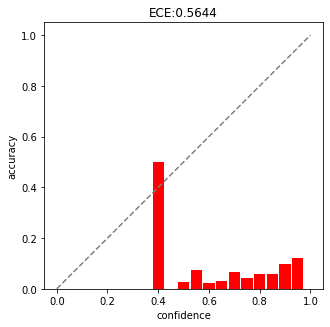

In [45]:
plot_figure(x,y,delta)

After training, ECE has considerably reduced. 

In [46]:
learner.load('stage-1');
probs, targets = learner.get_preds()
class_confidences, gt_idxs = probs.numpy(), targets.numpy()
ece, data = expected_caliberation_error(class_confidences,gt_idxs)

In [47]:
# hide
x = [l for l,h,ce,acc,conf in data]
y = [acc for l,h,ce,acc,conf in data]
delta = 1.0/20

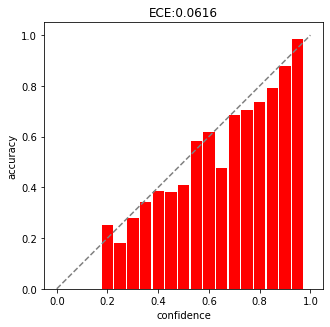

In [48]:
plot_figure(x,y,delta)

In [4]:
# hide
! sh finalise.sh 2020-01-20-expected-caliberation-error